In [1]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

# Spatial Transformer Networks

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

plt.ion()   # interactive mode

## Loading the Data

In [3]:
import torch
from torchvision import transforms, datasets

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform=transforms.Compose([
    #transforms.Grayscale(),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    #transforms.Normalize((0.4914, 0.4822, 0.4465),
    #                     (0.2023, 0.1994, 0.2010)),
    ])

training_data = datasets.ImageFolder(root='./data/training', transform=transform)
test_data = datasets.ImageFolder(root='./data/test', transform=transform)

from torch.utils.data import DataLoader

# Create data loaders
mini_batch_size = 64

train_dataloader = DataLoader(training_data, batch_size=65, shuffle=True, num_workers=1)
test_dataloader = DataLoader(test_data, batch_size=34, shuffle=True, num_workers=1)

## Depicting Spatial Transformer Networks

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 4)

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 3 * 3)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):
        # transform the input
        x = self.stn(x)

        # Perform the usual forward pass
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)


model = Net().to(device)

## Training the Model

In [5]:
learning_rate = 0.001

#optimizer = optim.Adam(model.parameters(), lr=learning_rate)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

train_loss_history = []
train_acc_history = []

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_dataloader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss_history.append(loss.item())
        
        if batch_idx % 3 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_dataloader.dataset),
                100. * batch_idx / len(train_dataloader), loss.item()))


test_loss_history = []
test_acc_history = []

def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_dataloader.dataset)
        
        test_loss_history.append(test_loss)
        test_acc_history.append(100. * correct / len(test_dataloader.dataset))
        
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(test_dataloader.dataset),
                      100. * correct / len(test_dataloader.dataset)))

## Visualizing the STN Results

/usr/local/anaconda3/lib/python3.10/site-packages/torch/nn/functional.py:4298: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/usr/local/anaconda3/lib/python3.10/site-packages/torch/nn/functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Train Epoch: 1 [0/650 (0%)]	Loss: 1.332206


/usr/local/anaconda3/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 1.3490, Accuracy: 57/170 (34%)

Train Epoch: 2 [0/650 (0%)]	Loss: 1.347222

Test set: Average loss: 1.3389, Accuracy: 57/170 (34%)

Train Epoch: 3 [0/650 (0%)]	Loss: 1.329089

Test set: Average loss: 1.3286, Accuracy: 57/170 (34%)

Train Epoch: 4 [0/650 (0%)]	Loss: 1.327410

Test set: Average loss: 1.3181, Accuracy: 57/170 (34%)

Train Epoch: 5 [0/650 (0%)]	Loss: 1.314538

Test set: Average loss: 1.3074, Accuracy: 57/170 (34%)

Train Epoch: 6 [0/650 (0%)]	Loss: 1.301950

Test set: Average loss: 1.2969, Accuracy: 57/170 (34%)

Train Epoch: 7 [0/650 (0%)]	Loss: 1.278665

Test set: Average loss: 1.2856, Accuracy: 57/170 (34%)

Train Epoch: 8 [0/650 (0%)]	Loss: 1.279219

Test set: Average loss: 1.2737, Accuracy: 57/170 (34%)

Train Epoch: 9 [0/650 (0%)]	Loss: 1.262155

Test set: Average loss: 1.2606, Accuracy: 57/170 (34%)

Train Epoch: 10 [0/650 (0%)]	Loss: 1.259995

Test set: Average loss: 1.2463, Accuracy: 57/170 (34%)

Train Epoch: 11 [0/650 (0%)]	Loss: 1.22359

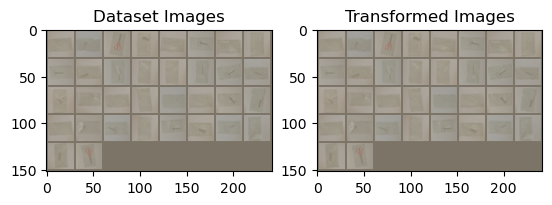

In [6]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp


# We want to visualize the output of the spatial transformers layer
# after the training, we visualize a batch of input images and
# the corresponding transformed batch using STN.


def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_dataloader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')

for epoch in range(1, 20 + 1):
    train(epoch)
    test()

# Visualize the STN transformation on some input batch
visualize_stn()

plt.ioff()
plt.show()

## Plots

In [ ]:
plt.plot(train_loss_history, label='Train')
plt.plot(test_loss_history, label='Validation')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(test_acc_history, label='Validation')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()